In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#drive is mounted with my colab account. So, I can access the folder from drive
import os
folder_path = ('/content/drive/MyDrive/potato_data/PlantVillage')
os.chdir(folder_path)


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/potato_data/PlantVillage',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    #Each element in the dataset is a tuple. First element is a batch of
    #32 elements of images. Second element is a batch of 32 elements of class labels as shown below

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


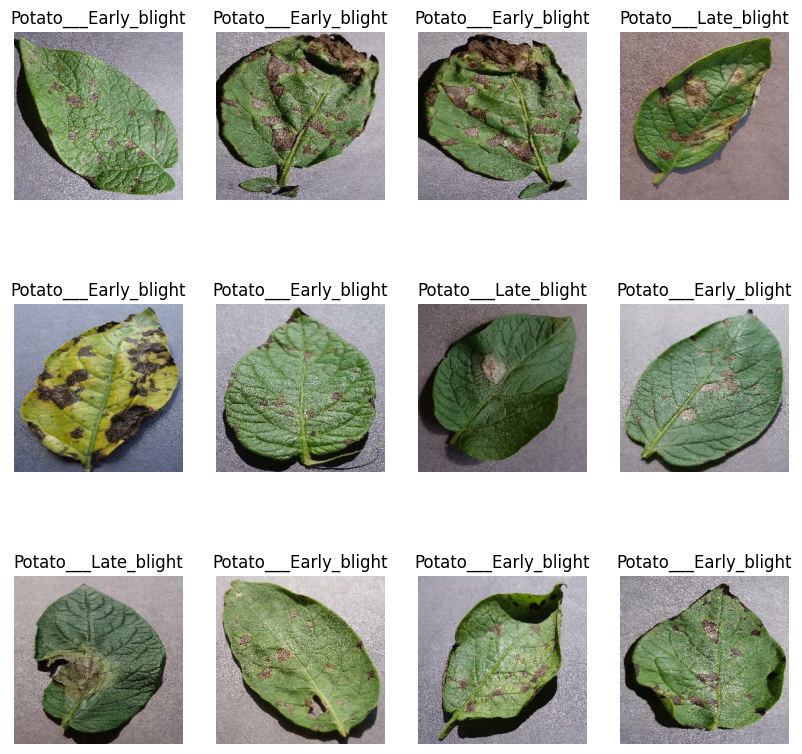

In [ ]:
#Data Visualization from the dataset
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
#Train/Test split operation on the dataset

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

In [ ]:
#Cache,shuffle and prefetch the data
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
#Data Augumentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#Model architecture - I have used Convolution nueral Network
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
 #Model Compiling - I have used adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric
 model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)


Epoch 1/50
54/54 [==============================] - 42s 565ms/step - loss: 0.9182 - accuracy: 0.5150 - val_loss: 0.8338 - val_accuracy: 0.6927
Epoch 2/50
54/54 [==============================] - 27s 501ms/step - loss: 0.6810 - accuracy: 0.7043 - val_loss: 0.5802 - val_accuracy: 0.7292
Epoch 3/50
54/54 [==============================] - 27s 504ms/step - loss: 0.4511 - accuracy: 0.8067 - val_loss: 0.4436 - val_accuracy: 0.7708
Epoch 4/50
54/54 [==============================] - 27s 488ms/step - loss: 0.2738 - accuracy: 0.8860 - val_loss: 0.2292 - val_accuracy: 0.9062
Epoch 5/50
54/54 [==============================] - 27s 494ms/step - loss: 0.2342 - accuracy: 0.9068 - val_loss: 0.4552 - val_accuracy: 0.8073
Epoch 6/50
54/54 [==============================] - 27s 496ms/step - loss: 0.1491 - accuracy: 0.9520 - val_loss: 0.3699 - val_accuracy: 0.8385
Epoch 7/50
54/54 [==============================] - 27s 494ms/step - loss: 0.1667 - accuracy: 0.9311 - val_loss: 0.0693 - val_accuracy: 0.9740

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 103ms/step - loss: 0.1141 - accuracy: 0.9648


In [ ]:
#plotting the accuracy and loss curves
history

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

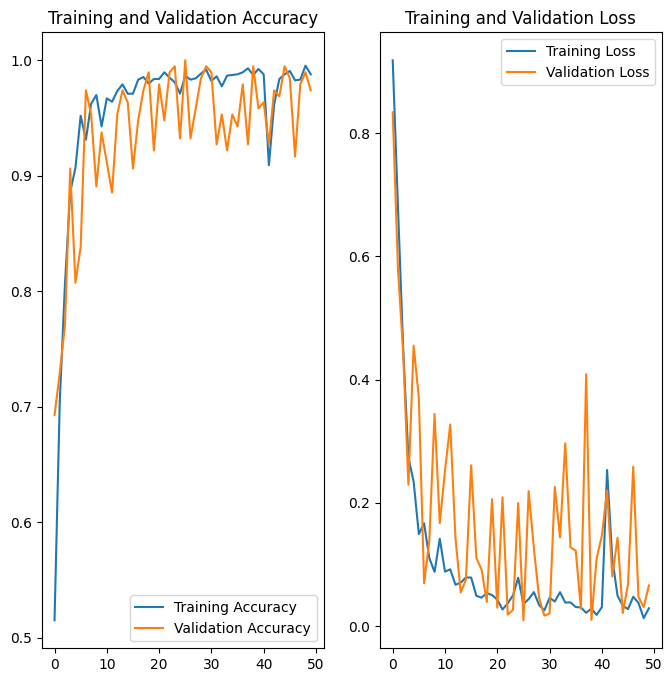

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 129ms/step
predicted label: Potato___Late_blight


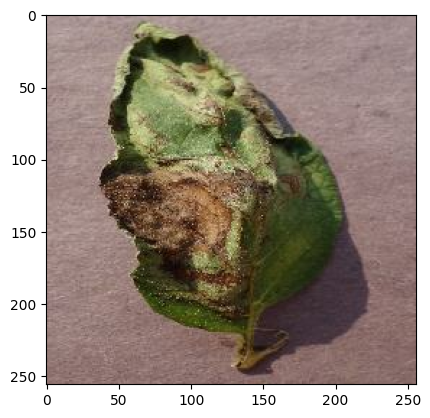

In [ ]:
#Lets Run the prediction on sample image:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [ ]:
#lets write and run the interferrence for a few sample  images:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 30ms/step


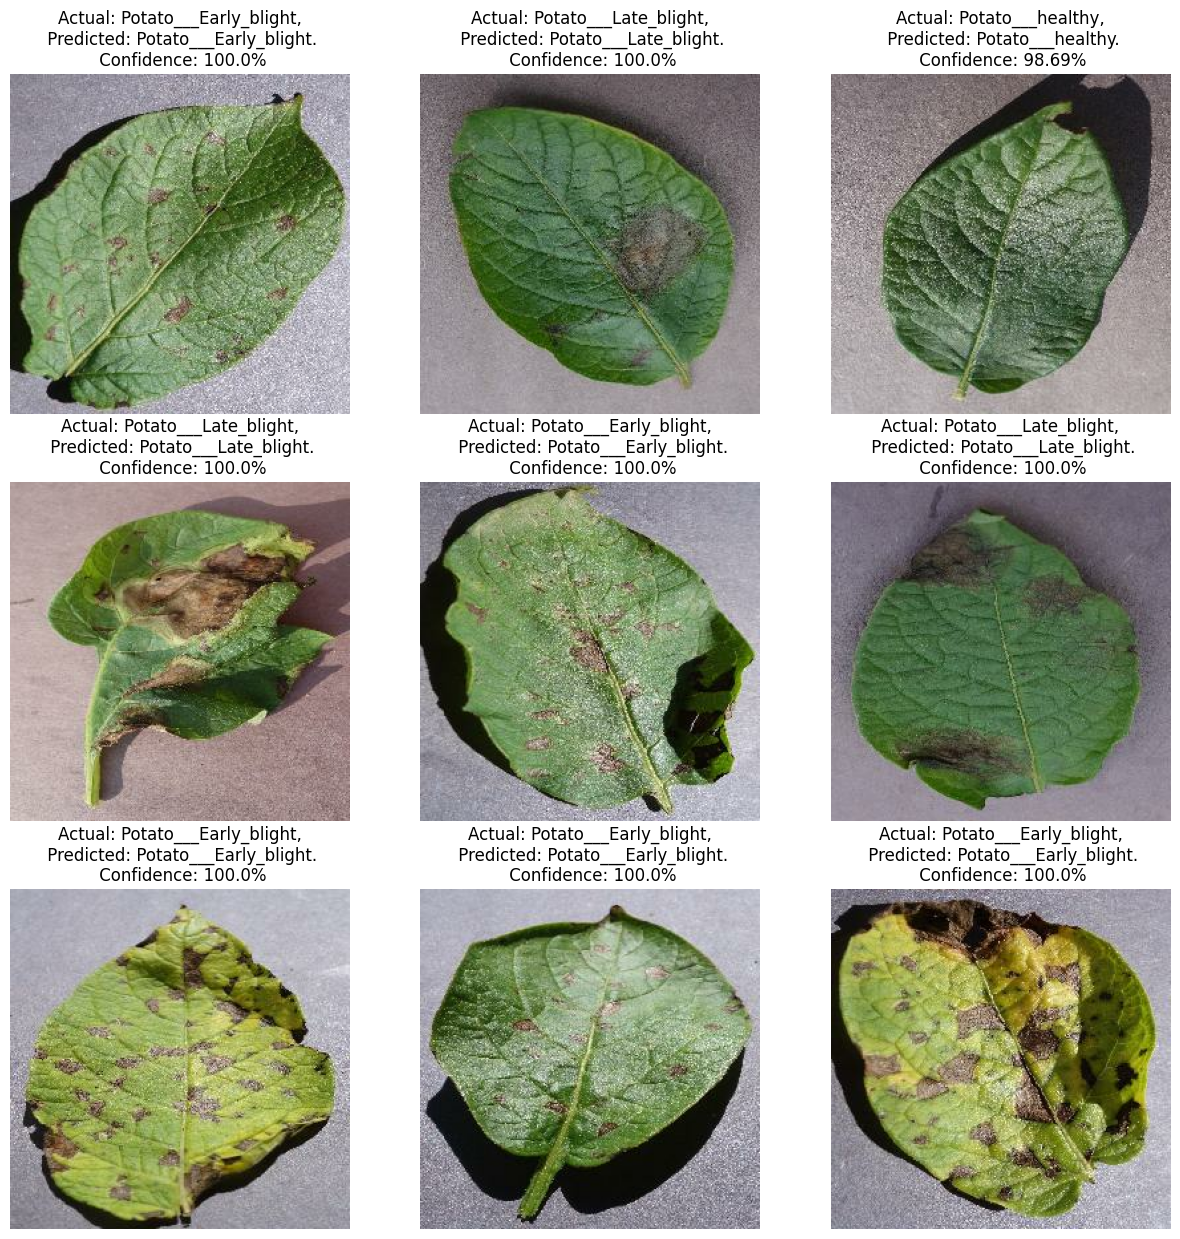

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
#Hence, I have successfully build a prediction model for classification of potato disease with deep learning convolutional nueral networks.

 * To use the VGG16 model for potato leaf disease classification*
  *Setup and Data Preparation*


In [1]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Define constants
BATCH_SIZE = 32
IMAGE_SIZE = 224  # VGG16 expects 224x224 images
CHANNELS = 3
EPOCHS = 50

# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/potato_data/PlantVillage',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Get class names
class_names = dataset.class_names


Mounted at /content/drive
Found 2152 files belonging to 3 classes.


Create Train, Validation, and Test Sets

In [2]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Cache, shuffle, and prefetch data
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


Data Augmentation

In [3]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


Load VGG16 Model

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)  # Adjust for your number of classes

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

 Train the Model

In [5]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/50
54/54 [==============================] - 49s 707ms/step - loss: 0.7126 - accuracy: 0.8582 - val_loss: 0.0996 - val_accuracy: 0.9583
Epoch 2/50
54/54 [==============================] - 35s 647ms/step - loss: 0.1447 - accuracy: 0.9514 - val_loss: 0.0919 - val_accuracy: 0.9635
Epoch 3/50
54/54 [==============================] - 36s 658ms/step - loss: 0.0890 - accuracy: 0.9699 - val_loss: 0.0450 - val_accuracy: 0.9844
Epoch 4/50
54/54 [==============================] - 36s 664ms/step - loss: 0.1201 - accuracy: 0.9578 - val_loss: 0.0885 - val_accuracy: 0.9792
Epoch 5/50
54/54 [==============================] - 36s 658ms/step - loss: 0.0897 - accuracy: 0.9653 - val_loss: 0.0377 - val_accuracy: 0.9844
Epoch 6/50
54/54 [==============================] - 35s 652ms/step - loss: 0.0969 - accuracy: 0.9711 - val_loss: 0.0475 - val_accuracy: 0.9792
Epoch 7/50
54/54 [==============================] - 35s 654ms/step - loss: 0.0903 - accuracy: 0.9745 - val_loss: 0.0511 - val_accuracy: 0.9844

 Evaluate the Mode

In [6]:
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')


8/8 [==============================] - 7s 563ms/step - loss: 0.0572 - accuracy: 0.9727
Test Loss: 0.05723743885755539
Test Accuracy: 0.97265625


 Plot Training History

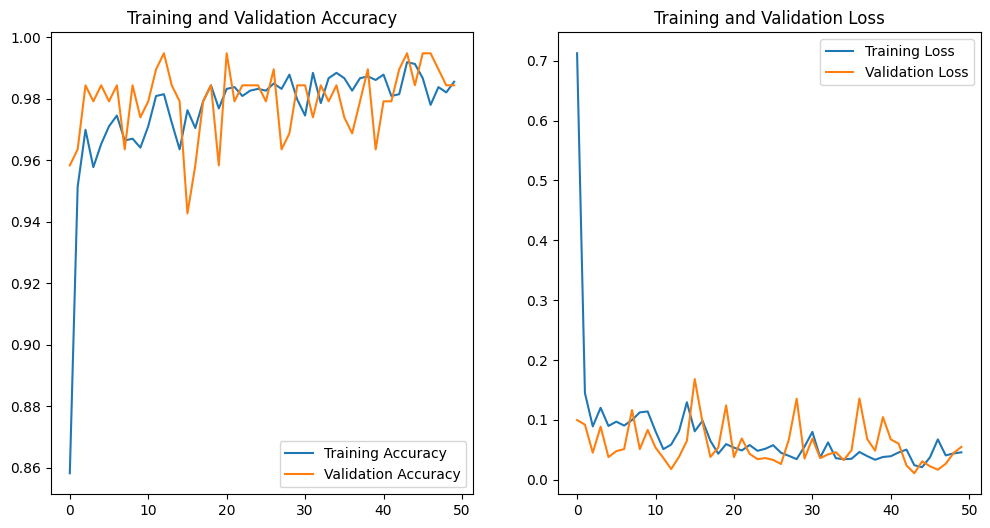

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Make Predictions

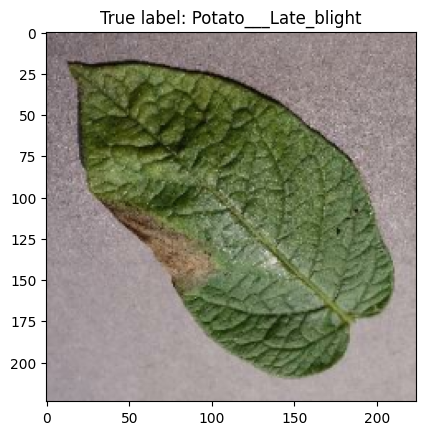

1/1 [==============================] - 0s 70ms/step
Predicted class: Potato___Late_blight with confidence: 91.42%


In [11]:
import numpy as np

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Example: Predict on a sample image
for images_batch, labels_batch in test_ds.take(1):
    for i in range(1):  # Test on a few images
        img = images_batch[i].numpy()
        plt.imshow(img.astype('uint8'))
        plt.title(f"True label: {class_names[labels_batch[i]]}")
        plt.show()

        predicted_class, confidence = predict(model, images_batch[i].numpy())
        print(f"Predicted class: {predicted_class} with confidence: {confidence}%")


In [ ]:
#Hence, I have successfully build a prediction VGG16 model for classification of potato disease with deep learning convolutional nueral networks.

Load VGG19 Model

In [12]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load VGG19 model without the top layer
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)  # Adjust for your number of classes

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


80134624/80134624 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

 Train the Model

In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/50
54/54 [==============================] - 42s 752ms/step - loss: 1.1876 - accuracy: 0.8310 - val_loss: 0.1801 - val_accuracy: 0.9531
Epoch 2/50
54/54 [==============================] - 41s 752ms/step - loss: 0.1166 - accuracy: 0.9589 - val_loss: 0.1655 - val_accuracy: 0.9427
Epoch 3/50
54/54 [==============================] - 41s 753ms/step - loss: 0.1193 - accuracy: 0.9572 - val_loss: 0.1323 - val_accuracy: 0.9635
Epoch 4/50
54/54 [==============================] - 42s 771ms/step - loss: 0.1571 - accuracy: 0.9450 - val_loss: 0.3017 - val_accuracy: 0.9115
Epoch 5/50
54/54 [==============================] - 41s 760ms/step - loss: 0.1503 - accuracy: 0.9554 - val_loss: 0.0958 - val_accuracy: 0.9688
Epoch 6/50
54/54 [==============================] - 42s 769ms/step - loss: 0.1123 - accuracy: 0.9647 - val_loss: 0.0770 - val_accuracy: 0.9792
Epoch 7/50
54/54 [==============================] - 41s 757ms/step - loss: 0.1382 - accuracy: 0.9531 - val_loss: 0.2411 - val_accuracy: 0.9271

 Evaluate the Model

In [14]:
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')


8/8 [==============================] - 5s 682ms/step - loss: 0.0457 - accuracy: 0.9883
Test Loss: 0.04566064849495888
Test Accuracy: 0.98828125


 Plot Training History

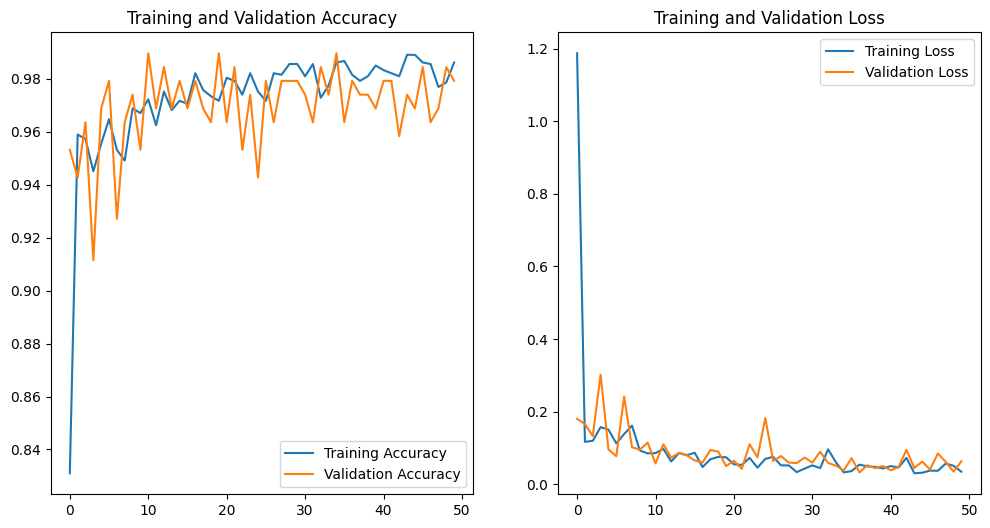

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Make Predictions

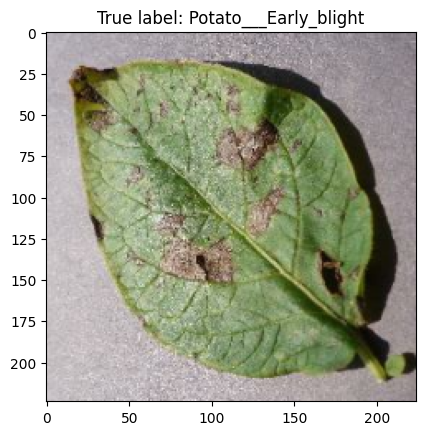

1/1 [==============================] - 0s 213ms/step
Predicted class: Potato___Early_blight with confidence: 100.0%


In [16]:
import numpy as np

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Example: Predict on a sample image
for images_batch, labels_batch in test_ds.take(1):
    for i in range(1):  # Test on a few images
        img = images_batch[i].numpy()
        plt.imshow(img.astype('uint8'))
        plt.title(f"True label: {class_names[labels_batch[i]]}")
        plt.show()

        predicted_class, confidence = predict(model, images_batch[i].numpy())
        print(f"Predicted class: {predicted_class} with confidence: {confidence}%")


Hence, I have successfully build a prediction VGG16 model for classification of potato disease with deep learning convolutional nueral networks.